In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
from datetime import timedelta
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
import numpy as np
import gymnasium as gym
from gymnasium import spaces

In [3]:
#Reading the Data File

file_path = 'zip://clustered_data_4months.zip!clustered_data_4months (2).geojson'
data = gpd.read_file(file_path, driver="GeoJSON")


data.head(), data.columns

print(data)
print(data.columns)
print(len(data))
print(len(data[data['cnprcp_mean']>0]))

/Users/shashwatraj/Documents/GitHub/Code-Lab_RL_PriorityObs/tatcenv/lib/python3.13/site-packages/pyogrio/raw.py:198: RuntimeWarning: driver GeoJSON does not support open option DRIVER
  return ogr_read(


                           time satellite instrument    swath_width  \
0     2024-05-22 00:00:00+00:00      Test       Test  278640.704057   
1     2024-05-22 00:02:00+00:00      Test       Test  277041.710508   
2     2024-05-22 00:04:00+00:00      Test       Test  275419.732317   
3     2024-05-22 00:06:00+00:00      Test       Test  273866.283658   
4     2024-05-22 00:08:00+00:00      Test       Test  272466.738302   
...                         ...       ...        ...            ...   
94475 2024-09-22 00:22:00+00:00      Test       Test  269537.568606   
94476 2024-09-22 00:24:00+00:00      Test       Test  267843.485083   
94477 2024-09-22 00:26:00+00:00      Test       Test  266231.255770   
94478 2024-09-22 00:28:00+00:00      Test       Test  264783.666193   
94479 2024-09-22 00:30:00+00:00      Test       Test  263569.285624   

       valid_obs  solar_hour time_range  month    lat_sat     lon_sat  \
0           True    9.006320    morning      5 -38.142798  134.265144   
1

In [4]:
# Preprocessing timestamp
data['time'] = pd.to_datetime(data['time'])


data['time_step'] = (data['time'] - data['time'].min()).dt.total_seconds()

In [5]:
world = gpd.read_file('110m_cultural.zip', layer = 'ne_110m_admin_0_boundary_lines_land')
geometry = [Point(xy) for xy in zip(data['lon_sat'], data['lat_sat'])]
geo_full = gpd.GeoDataFrame(data, geometry=geometry)
geo_full['ground_track'] = geo_full.apply(lambda row: 0 if world.contains(row.geometry).any() else 1, axis=1)
data['ground_track'] = geo_full['ground_track']

In [6]:
data['lat_rad'] = np.radians(data['lat_sat'])
data['lon_rad'] = np.radians(data['lon_sat'])

data['x'] = np.cos(data['lat_rad']) * np.cos(data['lon_rad'])
data['y'] = np.cos(data['lat_rad']) * np.sin(data['lon_rad'])
data['z'] = np.sin(data['lat_rad'])

In [7]:
encoder = OneHotEncoder(sparse_output=False)
time_range_encoded = encoder.fit_transform(data[['time_range']])
time_range_feature_names = encoder.get_feature_names_out(['time_range'])
time_range_df = pd.DataFrame(time_range_encoded, columns=time_range_feature_names, index=data.index)
data = pd.concat([data, time_range_df], axis=1)

In [8]:
scaler = MinMaxScaler()
cols_to_scale = ['x','y','z']
scaled_values = scaler.fit_transform(data[cols_to_scale])
data['x_norm'] = scaled_values[:, 0]
data['y_norm'] = scaled_values[:, 1]
data['z_norm'] = scaled_values[:, 2]

In [9]:
class SatelliteEnv(gym.Env):
    def __init__(self, df, alpha=1.0, gamma=1.0, mu=1.0):
        super(SatelliteEnv, self).__init__()
        self.df = df.reset_index(drop=True)
        self.n_steps = len(self.df)
        self.alpha = alpha
        self.gamma = gamma
        self.mu = mu

        # Action space: 0 = don't act, 1 = act.
        self.action_space = spaces.Discrete(2)

        # One-hot encoded time_range columns.
        self.one_hot_cols = [col for col in df.columns if col.startswith('time_range_')]
        n_one_hot = len(self.one_hot_cols)

        self.obs_dim = 4 + n_one_hot
        self.observation_space = spaces.Box(low=0.0, high=1.0, shape=(self.obs_dim,), dtype=np.float32)
        self._index = 0


    def reset(self, seed=None, options=None):
        self._index = 0
        return self._get_obs(), {}
    
    def step(self, action):
        reward = self._compute_reward(action)
        self._index += 1
        done = (self._index >= self.n_steps - 1)
        obs = self._get_obs() if not done else np.zeros(self.obs_dim, dtype=np.float32)
        terminated = done  # assuming episode termination
        truncated = False  # assuming no truncation
        return obs, reward, terminated, truncated, {}
    
    def _get_obs(self):
        row = self.df.iloc[self._index]
        # states : x_norm, y_norm, z_norm, ground_track.
        cont_features = np.array([
            row['x_norm'],
            row['y_norm'],
            row['z_norm'],
            float(row['ground_track'])
        ], dtype=np.float32)
        # One-hot encoded time_range features:
        one_hot_features = row[self.one_hot_cols].values.astype(np.float32)
        # Concatenate the encoded vector and state features to form the full state.
        obs = np.concatenate([cont_features, one_hot_features])
        return obs
    
    # Define the Reward Function
    # correct decision*intensity
    def _compute_reward(self, action):
        row = self.df.iloc[self._index]
        cnprcp_mean = row['cnprcp_mean']
        scale = 10000  # scaling factor to amplify small precipitation values
        if action == 1:
            if cnprcp_mean > 0:
                # Correct detection: give a base reward of 1 plus bonus proportional to intensity.
                reward = 1 + (cnprcp_mean * scale)
            else:
                # False positive: a small penalty for acting when there's no precipitation.
                reward = -0.1
        else:  # action == 0
            if cnprcp_mean > 0:
                reward = -0.001 #scale the negative penalty according to the intensity of precipitation
            else:
                reward = 0
        return reward
    
    #visualize reward distribution for the dataset

In [10]:
import torch
print(torch.backends.mps.is_available())

True


In [11]:
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

all_f1_scores = []
all_precision_scores = []
all_recall_scores = []
all_rewards = []
all_test_results = []

tscv = TimeSeriesSplit(n_splits=3)

for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(data)):
    train_df = data.iloc[train_idx]
    test_df = data.iloc[test_idx]

    train_env = SatelliteEnv(train_df, alpha=20.0, gamma=1.0, mu=1.0)
    check_env(train_env, warn=True)

    # 3) Train the QRDQN model (a distributional RL algorithm)
    model = DQN("MlpPolicy", train_env, verbose=0)
    model.learn(total_timesteps=100000)  

    # 4) Evaluate on the test split
    test_env = SatelliteEnv(test_df, alpha=20.0, gamma=1.0, mu=1.0)
    obs, _ = test_env.reset()

    done = False
    total_reward = 0.0
    predicted_actions = []
    actual_labels = []
    tmp_lat = []
    tmp_lon = []
    tmp_test_results = {'actual': [], 'predicted': [], 'lat': [], 'lon': []}

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        predicted_actions.append(action)
        
        # Get actual label from cnprcp_mean: 1 if > 0, else 0.
        current_cprcp = test_env.df.iloc[test_env._index]['cnprcp_mean']
        actual_label = 1 if current_cprcp > 0 else 0
        actual_labels.append(int(actual_label))
        tmp_lat.append(test_env.df.iloc[test_env._index]['lat_sat'])
        tmp_lon.append(test_env.df.iloc[test_env._index]['lon_sat'])

        obs, reward, terminated, truncated, info = test_env.step(action)
        total_reward += reward
        done = terminated or truncated

    f1 = f1_score(actual_labels, predicted_actions, zero_division=0)
    precision = precision_score(actual_labels, predicted_actions, zero_division=0)
    recall = recall_score(actual_labels, predicted_actions, zero_division=0)
    tmp_test_results['actual']+= actual_labels
    tmp_test_results['predicted']+= predicted_actions
    tmp_test_results['lat']+= tmp_lat
    tmp_test_results['lon']+= tmp_lon
    all_test_results.append(tmp_test_results)
    all_f1_scores.append(f1)
    all_precision_scores.append(precision)
    all_recall_scores.append(recall)
    all_rewards.append(total_reward)
    print(f"Fold {fold_idx}: F1_Score = {f1:.3f}, Precision_Score = {precision:.3f}, Recall_Score = {recall:.3f}, Total Reward = {total_reward:.3f}")

mean_f1 = np.mean(all_f1_scores)
mean_reward = np.mean(all_rewards)
print(f"\nOverall: Mean F1 = {mean_f1:.3f}, Mean Cumulative Reward = {mean_reward:.3f}")

Fold 0: F1_Score = 0.207, Precision_Score = 0.119, Recall_Score = 0.794, Total Reward = 763.960
Fold 1: F1_Score = 0.229, Precision_Score = 0.135, Recall_Score = 0.744, Total Reward = 765.938
Fold 2: F1_Score = 0.147, Precision_Score = 0.082, Recall_Score = 0.699, Total Reward = 254.002

Overall: Mean F1 = 0.194, Mean Cumulative Reward = 594.634


In [14]:
combined_dqn = {"actual": [], "predicted": [], "lat": [], "lon": []}
for result in all_test_results:
    if isinstance(result, dict):
        for key in combined_dqn.keys():
            combined_dqn[key].extend(result[key])
    else:
        print("Unexpected element type:", type(result))
        
results_df = pd.DataFrame(combined_dqn)

,actual,predicted,lat_sat,lon_sat,confusion
0,0,0,-18.153519,59.909504,TN
1,0,1,-12.122283,64.622522,FP
2,0,1,-5.992427,69.106591,FP
3,0,1,0.185256,73.481981,FP
4,0,1,6.363448,77.862262,FP
5,0,1,12.494596,82.361394,FP
6,0,1,18.527177,87.100863,FP
7,1,1,24.401434,92.216803,TP
8,0,1,30.044107,97.866535,FP
9,0,0,35.361786,104.232341,TN


<Axes: xlabel='confusion'>

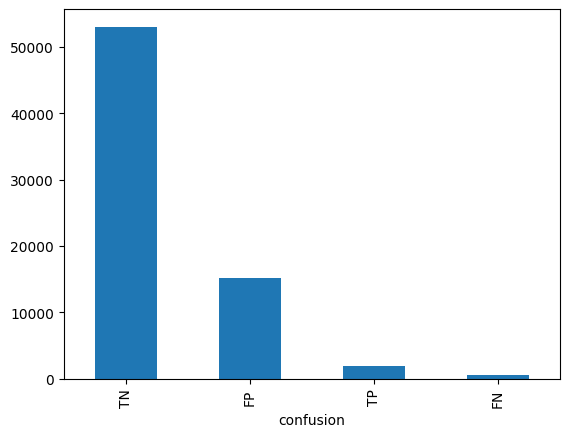

In [15]:
results_df_dqn = results_df.rename(columns={"lat": "lat_sat", "lon": "lon_sat"})

def modelResult(actual, predicted):
    if actual == 1 and predicted == 1:
        return "TP"
    elif actual == 0 and predicted == 1:
        return "FP"
    elif actual == 0 and predicted == 0:
        return "TN"
    elif actual == 1 and predicted == 0:
        return "FN"

results_df_dqn["confusion"] = results_df.apply(
    lambda row: modelResult(row["actual"], row["predicted"]), axis=1
)

display(results_df_dqn.head(10))
results_df_dqn['confusion'].value_counts().plot(kind='bar')

In [20]:
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(results_df_dqn["lon_sat"], results_df_dqn["lat_sat"])]
gdf = gpd.GeoDataFrame(results_df_dqn, geometry=geometry)
gdf.crs = "EPSG:4326"

display(gdf.head())

,actual,predicted,lat_sat,lon_sat,confusion,geometry
0,0,0,-18.153519,59.909504,TN,POINT (59.9095 -18.15352)
1,0,1,-12.122283,64.622522,FP,POINT (64.62252 -12.12228)
2,0,1,-5.992427,69.106591,FP,POINT (69.10659 -5.99243)
3,0,1,0.185256,73.481981,FP,POINT (73.48198 0.18526)
4,0,1,6.363448,77.862262,FP,POINT (77.86226 6.36345)


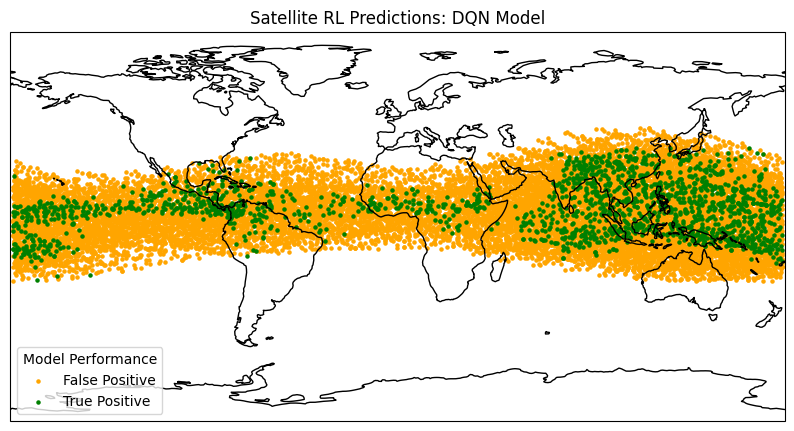

In [25]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()

fp_subset = gdf[gdf["confusion"] == "FP"]
tp_subset = gdf[gdf["confusion"] == "TP"]

fp_subset.plot(
    ax=ax,
    marker='o',
    color="orange",
    label="False Positive",
    transform=ccrs.PlateCarree(),
    markersize=5
)

tp_subset.plot(
    ax=ax,
    marker='o',
    color="green",
    label="True Positive",
    transform=ccrs.PlateCarree(),
    markersize=5
)

plt.legend(title="Model Performance", loc="lower left")
plt.title("Satellite RL Predictions: DQN Model")
plt.show()

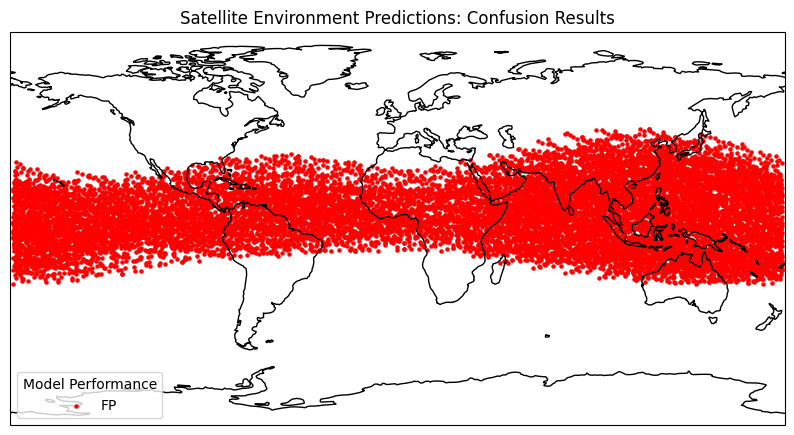

In [22]:
color_map = {
    "FP": "red",
}

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()

for label, color in color_map.items():
    subset = gdf[gdf["confusion"] == label]
    subset.plot(
        ax=ax,
        marker='o',
        color=color,
        label=label,
        transform=ccrs.PlateCarree(),
        markersize=5
    )

plt.legend(title="Model Performance", loc="lower left")
plt.title("Satellite Environment Predictions: Confusion Results")
plt.show()

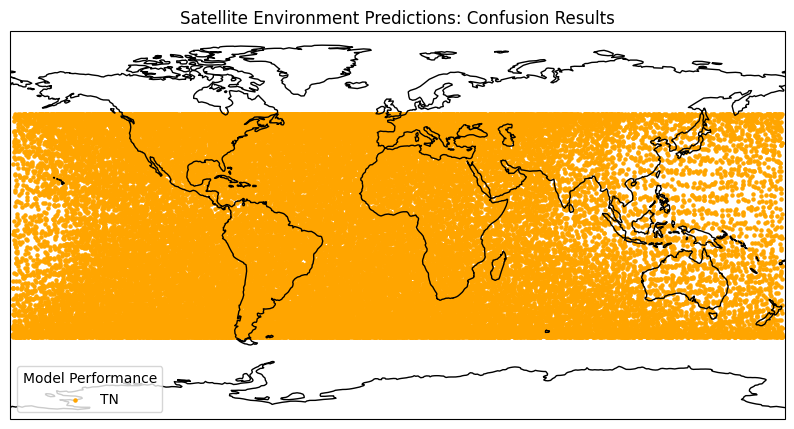

In [56]:
color_map = {
    "TN": "orange",
}

fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': ccrs.PlateCarree()})
ax.coastlines()
ax.set_global()

for label, color in color_map.items():
    subset = gdf[gdf["confusion"] == label]
    subset.plot(
        ax=ax,
        marker='o',
        color=color,
        label=label,
        transform=ccrs.PlateCarree(),
        markersize=5
    )

plt.legend(title="Model Performance", loc="lower left")
plt.title("Satellite Environment Predictions: Confusion Results")
plt.show()